# Docling

Docling simplifies document processing, parsing diverse formats — including advanced PDF understanding — and providing seamless integrations with the gen AI ecosystem.

## References
[Docling: An Efficient Open-Source Toolkit for AI-driven Document Conversion](https://arxiv.org/pdf/2501.17887)  
[Docling Project](https://docling-project.github.io/docling/)

In [56]:
import sys
import os
import time
from pathlib import Path
import rich
from IPython.display import display, Markdown

# Params

In [57]:
path_data = Path() / "data"
path_input = path_data / "raw"
path_output = path_data / "interim" / "docling"  # Store converted

path_output.mkdir(exist_ok=True, parents=True)

In [58]:
IMAGE_RESOLUTION_SCALE = 2.0  # scale=1 correspond of a standard 72 DPI image, also needed to get pages images

## PDF Conversion

In [59]:
path_artifacts = Path.home() / ".cache" / "docling" / "models"  # Docling models are stored here

path_artifacts.exists()

True

In [60]:
from docling.document_converter import DocumentConverter
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem


input_file = "Divulgacion Planetaria Althera.pdf"  # document per local path or URL
output_file = "Divulgacion-Planetaria-Althera.md"
input_doc_path = path_input / input_file


pipeline_options = PdfPipelineOptions(
    artifacts_path=path_artifacts.as_posix(),
    )
pipeline_options.do_ocr = True
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.do_cell_matching = True  # default
pipeline_options.table_structure_options.mode =  TableFormerMode.ACCURATE  # default, also FAST
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True


converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    },
)

# Conversion
tm_start = time.perf_counter()
conv_res = converter.convert(input_doc_path.as_posix())
tm_end = time.perf_counter()
tm_process = tm_end - tm_start
print(f"{tm_process=:0.2f} segs")


# Save pages as images
root_filename_elements = input_doc_path.stem

for page_no, page in conv_res.document.pages.items():
    page_no = page.page_no
    page_image_filename = path_output / f"{root_filename_elements}-{page_no}.png"
    with page_image_filename.open("wb") as fp:
        page.image.pil_image.save(fp, format="PNG")

# Save images of figures and tables
table_counter = 0
picture_counter = 0
for element, _level in conv_res.document.iterate_items():
    if isinstance(element, TableItem):
        table_counter += 1
        element_image_filename = (
            path_output / f"{root_filename_elements}-table-{table_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")

    if isinstance(element, PictureItem):
        picture_counter += 1
        element_image_filename = (
            path_output / f"{root_filename_elements}-picture-{picture_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")

2025-09-04 22:39:51,155 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-09-04 22:39:51,160 - INFO - Going to convert document batch...
2025-09-04 22:39:51,160 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 0fa808b112455bc067a1e2ac31d7699b
2025-09-04 22:39:51,160 - INFO - Accelerator device: 'cpu'
2025-09-04 22:39:53,271 - INFO - Accelerator device: 'cpu'
2025-09-04 22:39:53,876 - INFO - Accelerator device: 'cpu'
2025-09-04 22:39:54,990 - INFO - Processing document Divulgacion Planetaria Althera.pdf
c:\Users\manua\Documents\repos\dslabs\dslab-docai\.venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\manua\Documents\repos\dslabs\dslab-docai\.venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pi

tm_process=83.09 segs


`pipeline_options.table_structure_options.do_cell_matching=True` (default)
1. The table structure model infers the table structure
2. Attemps to fill the table structure with the original table cells from the pdf backend
If set to False:
2. Fill the table structure with the predicted cells content. This may improve output quality if you find that multiple columns in extracted tables are erroneously merged into one.

[Control PDF table extraction options](https://docling-project.github.io/docling/usage/#control-pdf-table-extraction-options)


## Conversion Confidence

In [61]:
type(conv_res.confidence)

docling.datamodel.base_models.ConfidenceReport

In [62]:
# Users can and should safely focus on the document-level grade fields — mean_grade and low_grade — to assess overall conversion quality
# https://docling-project.github.io/docling/concepts/confidence_scores/#purpose
print(f"{conv_res.confidence.mean_grade=}")
print(f"{conv_res.confidence.low_grade=}")

conv_res.confidence.mean_grade=<QualityGrade.EXCELLENT: 'excellent'>
conv_res.confidence.low_grade=<QualityGrade.EXCELLENT: 'excellent'>


# Docling Document

Pydantic data structure to set a structured interface to represent the document and its elements (tables, pictures, sections, etc.)

In [63]:
print(f"{type(conv_res)=}")
doc = conv_res.document
print(f"{type(doc)=}")

type(conv_res)=<class 'docling.datamodel.document.ConversionResult'>
type(doc)=<class 'docling_core.types.doc.document.DoclingDocument'>


In [64]:
# Save as json
doc.save_as_json(path_output / "docling-doc-Divulgacion-Planetaria-Althera.json")

### Document Structure

In [ ]:
# Content items
# This items contains the actual text (in variables .text and .orig)
print(f"{type(doc.texts)=}")  # section headers, lists, paragraphs, ...
print(f"{type(doc.tables)=}")
print(f"{type(doc.pictures)=}")
print(f"{type(doc.key_value_items)=}")

type(doc.texts)=<class 'list'>
type(doc.tables)=<class 'list'>
type(doc.pictures)=<class 'list'>
type(doc.key_value_items)=<class 'list'>


#### Texts

In [ ]:
rich.print(doc.texts[0])
# parent=RefItem(cref='#/body'),
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>, not document title

SectionHeaderItem(
    self_ref='#/texts/0',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=113.88,
                t=706.4210649804688,
                r=487.098,
                b=687.5300649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 37)
        )
    ],
    orig='Un nuevo y fascinante vecino: Althéra',
    text='Un nuevo y fascinante vecino: Althéra',
    formatting=None,
    hyperlink=None,
    level=1
)

In [67]:
rich.print(doc.texts[1])
# parent=RefItem(cref='#/body')
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>
# level=1

SectionHeaderItem(
    self_ref='#/texts/1',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=671.2630649804688,
                r=120.13,
                b=660.2120649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 6)
        )
    ],
    orig='Índice',
    text='Índice',
    formatting=None,
    hyperlink=None,
    level=1
)

In [ ]:
rich.print(doc.texts[2])
# parent=RefItem(cref='#/groups/0'),
# content_layer=<ContentLayer.BODY: 'body'>,
# label=<DocItemLabel.LIST_ITEM: 'list_item'>, -> Indice (group0)
# enumerated=True,
# enumerated=True,
# marker='1.'  (in list_item)

ListItem(
    self_ref='#/texts/2',
    parent=RefItem(cref='#/groups/0'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.LIST_ITEM: 'list_item'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=94.44,
                t=653.9790649804688,
                r=259.716,
                b=644.3820649804687,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 30)
        )
    ],
    orig='1. Historia del descubrimiento',
    text='Historia del descubrimiento',
    formatting=None,
    hyperlink=None,
    enumerated=True,
    marker='1.'
)

In [78]:
rich.print(doc.texts[12])
# parent=RefItem(cref='#/body'),
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
# level=1

SectionHeaderItem(
    self_ref='#/texts/12',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=490.4230649804688,
                r=256.322,
                b=479.3720649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 30)
        )
    ],
    orig='1. Historia del descubrimiento',
    text='1. Historia del descubrimiento',
    formatting=None,
    hyperlink=None,
    level=1
)

In [79]:
rich.print(doc.texts[13])
# parent=RefItem(cref='#/body'),
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
# level=1 (sections layers are not properly captured)

SectionHeaderItem(
    self_ref='#/texts/13',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=464.8100649804688,
                r=320.083,
                b=455.3650649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 48)
        )
    ],
    orig='1.1 Primeras observaciones y sospechas iniciales',
    text='1.1 Primeras observaciones y sospechas iniciales',
    formatting=None,
    hyperlink=None,
    level=1
)

In [ ]:
rich.print(doc.texts[14])
# parent=RefItem(cref='#/body'),
# label=<DocItemLabel.TEXT: 'text'>,

TextItem(
    self_ref='#/texts/14',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.TEXT: 'text'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=442.0590649804688,
                r=512.843,
                b=336.7020649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 622)
        )
    ],
    orig='El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una 
campaña de observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela 
Estay . La misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, 
pero un patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. 
El análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos 
estrellas en órbita mutua y varios cuerpos orbitando de forma circumbinaria.',
    text='El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una 
campaña de observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela 
Estay . La misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, 
pero un patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. 
El análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos 
estrellas en órbita mutua y varios cuerpos orbitando de forma circumbinaria.',
    formatting=None,
    hyperlink=None
)

#### Tables

In [81]:
len(doc.tables)

2

In [82]:
print(doc.tables[0].parent)
print(doc.tables[0].content_layer)

cref='#/body'
ContentLayer.BODY


In [83]:
display(Markdown(doc.tables[0].export_to_markdown(doc=doc)))

| Parámetro               | Althéra A   | Althéra B   |
|-------------------------|-------------|-------------|
| Masa                    | 1,28M ☉     | 0,82M ☉     |
| Radio                   | 1,32 R ☉    | 0,74 R ☉    |
| Luminosidad             | 2,4 L ☉     | 0,39 L ☉    |
| Temperatura superficial | 6.350 K     | 4.950 K     |

In [ ]:
display(Markdown(doc.tables[1].export_to_markdown(doc=doc)))
# check empty cell
# check double data cell

| Cuerpo                     | Tipo                 | Distancia media (UA)   | Periodo orbital (días terrestres)   |
|----------------------------|----------------------|------------------------|-------------------------------------|
| Thyros I ( HD 4579 Ab )    | Rocoso               | 0,78                   | 215                                 |
| Névalis II ( HD 4579 Ac )  | Rocoso               | 1,36                   | 397                                 |
| Cinturón de Arges          | Asteroides metálicos | 1,65 - 1,85            |                                     |
| Aurelia III ( HD 4579 Ad ) | Rocoso, habitable    | 2,21                   | 589                                 |
| Zephyros IV ( HD 4579 Ae ) | Gigante gaseoso      | 4,92                   | 2.689                               |
| Krion V ( HD 4579 Af )     | Gigante helado       | 8,14                   | 6.873                               |

#### Pictures

In [85]:
print(doc.pictures[0].parent)
print(doc.pictures[0].content_layer)

cref='#/body'
ContentLayer.BODY


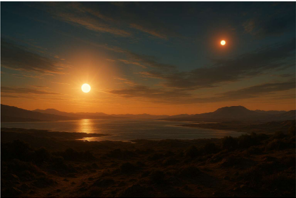

In [86]:
doc.pictures[0].get_image(doc=doc)

In [87]:
doc.pictures[0].footnotes

[]

In [88]:
doc.pictures[0].caption_text(doc=doc)

'Figure 1 Atardecer en Althera'

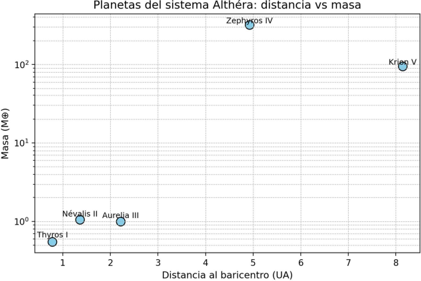

In [182]:
doc.pictures[1].get_image(doc=doc)

In [183]:

print(f"{doc.pictures[1].caption_text(doc=doc)=}")
print(f"{doc.pictures[1].footnotes=}")

doc.pictures[1].caption_text(doc=doc)=''
doc.pictures[1].footnotes=[]


Figure 2 Notas de Mariela Estay el día del descubrimiento


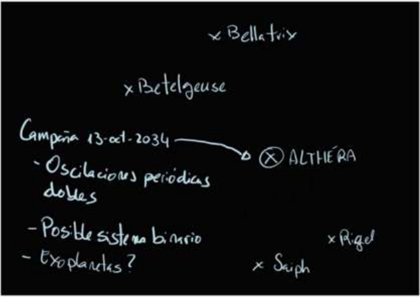

In [92]:
print(doc.pictures[2].caption_text(doc=doc))
doc.pictures[2].get_image(doc=doc)

In [93]:
doc.pictures[2].get_annotations()

[]

In [96]:
# rich.print(doc.pictures[2])  (base64 field)
# children=[RefItem(cref='#/texts/228'), RefItem(cref='#/texts/229'), RefItem(cref='#/texts/230')],
# captions=[RefItem(cref='#/texts/228')],
# annotations=[]
# references=[],
# footnotes=[],

In [102]:
doc.texts[228].orig # caption

'Figure 2 Notas de Mariela Estay el día del descubrimiento'

In [ ]:
doc.texts[229].orig  # content (ocr)

'13-cl'

In [108]:
doc.texts[230].orig # content (ocr)

'2034'

#### Key Value Items

In [109]:
doc.key_value_items

[]

### Document Structure

In [130]:
# Content structure items

print(f"{type(doc.body)=}")  # all elements: texts, pictures, tables and groups
print(f"{type(doc.furniture)=}")  # elements outside body
print(f"{type(doc.groups)=}")  # pieces of text like lists and so on

type(doc.body)=<class 'docling_core.types.doc.document.GroupItem'>
type(doc.furniture)=<class 'docling_core.types.doc.document.GroupItem'>
type(doc.groups)=<class 'list'>


C:\Users\manua\AppData\Local\Temp\ipykernel_14672\1248164015.py:4: DeprecationWarning: deprecated
  print(f"{type(doc.furniture)=}")  # elements outside body


In [131]:
doc.furniture

C:\Users\manua\AppData\Local\Temp\ipykernel_14672\970953479.py:1: DeprecationWarning: deprecated
  doc.furniture


GroupItem(self_ref='#/furniture', parent=None, children=[], content_layer=<ContentLayer.FURNITURE: 'furniture'>, name='_root_', label=<GroupLabel.UNSPECIFIED: 'unspecified'>)

In [140]:
doc.groups[:6]
# #/groups/0': index
# #/groups/1

[ListGroup(self_ref='#/groups/0', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/2'), RefItem(cref='#/texts/3'), RefItem(cref='#/texts/4'), RefItem(cref='#/texts/5'), RefItem(cref='#/texts/6'), RefItem(cref='#/texts/7'), RefItem(cref='#/texts/8'), RefItem(cref='#/texts/9'), RefItem(cref='#/texts/10'), RefItem(cref='#/texts/11')], content_layer=<ContentLayer.BODY: 'body'>, name='list', label=<GroupLabel.LIST: 'list'>),
 ListGroup(self_ref='#/groups/1', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/17'), RefItem(cref='#/texts/18'), RefItem(cref='#/texts/19')], content_layer=<ContentLayer.BODY: 'body'>, name='list', label=<GroupLabel.LIST: 'list'>),
 GroupItem(self_ref='#/groups/2', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/21')], content_layer=<ContentLayer.BODY: 'body'>, name='group', label=<GroupLabel.KEY_VALUE_AREA: 'key_value_area'>),
 ListGroup(self_ref='#/groups/3', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/

In [134]:
doc.texts[21].orig

'Divulgación Planetaria: 2025-07'

In [135]:
doc.texts[22].orig

'1.3 Descubrimiento revolucionario de la zona habitable circumbinaria'

In [136]:
doc.texts[23].orig

'El hallazgo más impactante llegó en 2034, cuando la misión LUVOIR-B (Large UV/Optical/IR Surveyor) detectó la firma espectral de vapor de agua, oxígeno molecular y metano en la atmósfera de Aurelia III , un planeta ubicado en la zona habitable del sistema, orbitando a ambos soles. Este fue el primer caso documentado de un mundo potencialmente habitable en un sistema binario cercano -a tan solo 42,7 años luz de la Tierra -, lo que lo convierte en un candidato ideal para futuras misiones de exploración interestelar.'

In [ ]:
# group 0 inspection
rich.print(doc.groups[0])

for el_child in doc.groups[0].children:
    el_child_ref = el_child.cref.split("/")  # #/texts/N
    el_child_kind = el_child_ref[1]
    el_child_id = int(el_child_ref[2])
    if el_child_kind == "texts":
        el_child_id_text = doc.texts[el_child_id].text
        print(f"{el_child_id}: {el_child_id_text} ")

ListGroup(
    self_ref='#/groups/0',
    parent=RefItem(cref='#/body'),
    children=[
        RefItem(cref='#/texts/2'),
        RefItem(cref='#/texts/3'),
        RefItem(cref='#/texts/4'),
        RefItem(cref='#/texts/5'),
        RefItem(cref='#/texts/6'),
        RefItem(cref='#/texts/7'),
        RefItem(cref='#/texts/8'),
        RefItem(cref='#/texts/9'),
        RefItem(cref='#/texts/10'),
        RefItem(cref='#/texts/11')
    ],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

2: Historia del descubrimiento 
3: Conoce a Althéra 
4: Los soles de Althéra 
5: Estructura general de Althéra 
6: Planetas interiores 
7: Planetas exteriores 
8: Lunas y satélites menores 
9: Fenómenos destacados 
10: Habitabilidad y astrobiología 
11: Conclusiones y perspectivas futuras 


In [ ]:
def display_group(idx):  # doc not added as arg
    rich.print(doc.groups[idx])

    for el_child in doc.groups[idx].children:
        el_child_ref = el_child.cref.split("/")  # #/texts/N
        el_child_kind = el_child_ref[1]
        el_child_id = int(el_child_ref[2])
        if el_child_kind == "texts":
            el_child_id_text = doc.texts[el_child_id].orig
            print(f"{el_child_id}: {el_child_id_text} ")

display_group(1)

ListGroup(
    self_ref='#/groups/1',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/17'), RefItem(cref='#/texts/18'), RefItem(cref='#/texts/19')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

17: · ELT (Extremely Large Telescope) en el Desierto de Atacama para espectroscopía de alta resolución. 
18: · Telescopio Espacial Nancy Grace Roman para fotometría de gran precisión en tránsitos. 
19: · Interferometría de radio desde la red Very Long Baseline Array (VLBA) para afinar la distancia y parámetros orbitales del sistema. 


In [150]:
display_group(2)

GroupItem(
    self_ref='#/groups/2',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/21')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='group',
    label=<GroupLabel.KEY_VALUE_AREA: 'key_value_area'>
)

21: Divulgación Planetaria: 2025-07 


In [151]:
display_group(3)

ListGroup(
    self_ref='#/groups/3',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/26'), RefItem(cref='#/texts/27'), RefItem(cref='#/texts/28')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

26: 1. Dinámica circumbinaria estable - demostró que los planetas pueden mantener órbitas estables y climas equilibrados alrededor de dos soles, desafiando modelos anteriores. 
27: 2. Química atmosférica compleja - Aurelia III presenta una mezcla de gases que, en equilibrio fotoquímico, sugieren procesos biológicos o geoquímicos activos. 
28: 3. Proximidad relativa - su cercanía permite observaciones directas en la próxima década con telescopios como el Habitable Worlds Observatory (HWO) y misiones de espectrometría directa de superficie como Starshot Spectra . 


In [154]:
# truncated list by page 
display_group(4)

ListGroup(
    self_ref='#/groups/4',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/35')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

35: · Althéra A ( HD 4579 A ), una enana amarilla-blanca de tipo F7V, más masiva y luminosa que el Sol. 


In [155]:
# truncated list
display_group(5)

GroupItem(
    self_ref='#/groups/5',
    parent=RefItem(cref='#/body'),
    children=[RefItem(cref='#/texts/37')],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='group',
    label=<GroupLabel.KEY_VALUE_AREA: 'key_value_area'>
)

37: Divulgación Planetaria: 2025-07 


In [ ]:
# rich.print(doc.body )  # root of the document layout

## Export document to Markdown

In [158]:
# Remove headers
HEADERS = "Divulgación Planetaria: 2025-07"

lst_el_headers = []
for el in doc.texts:
    if el.orig == HEADERS:
        lst_el_headers.append(el)

n_headers = len(lst_el_headers)
print(f"{n_headers=}")
if len(lst_el_headers) <= 14:  # expected maximum number of headers
    doc.delete_items(node_items=lst_el_headers)


2025-09-04 23:21:31,709 - INFO - deleted item in tree at stack: (157,) => #/texts/226
2025-09-04 23:21:31,709 - INFO - deleted item in tree at stack: (140, 0) => #/texts/206
2025-09-04 23:21:31,709 - INFO - deleted item in tree at stack: (131,) => #/texts/197
2025-09-04 23:21:31,709 - INFO - deleted item in tree at stack: (120, 0) => #/texts/177
2025-09-04 23:21:31,709 - INFO - deleted item in tree at stack: (106,) => #/texts/158
2025-09-04 23:21:31,716 - INFO - deleted item in tree at stack: (91, 0) => #/texts/136
2025-09-04 23:21:31,717 - INFO - deleted item in tree at stack: (78, 0) => #/texts/113
2025-09-04 23:21:31,719 - INFO - deleted item in tree at stack: (66,) => #/texts/94
2025-09-04 23:21:31,719 - INFO - deleted item in tree at stack: (61,) => #/texts/78
2025-09-04 23:21:31,720 - INFO - deleted item in tree at stack: (49, 0) => #/texts/64
2025-09-04 23:21:31,720 - INFO - deleted item in tree at stack: (38,) => #/texts/54
2025-09-04 23:21:31,720 - INFO - deleted item in tree 

n_headers=13


In [ ]:
# Try to reprocess handwritten images

filename_img3 = path_output / "Divulgacion Planetaria Althera-picture-3.png"

img_converter = (
        DocumentConverter(  # all of the below is optional, has internal defaults.
            allowed_formats=[
                InputFormat.IMAGE,
            ],  # whitelist formats, non-matching files are ignored.
        )
    )

tm_start = time.perf_counter()
conv_res_img3 = img_converter.convert(filename_img3.as_posix())
tm_end = time.perf_counter()
tm_process = tm_end - tm_start
print(f"{tm_process=:0.2f} segs")

for i, el_text in enumerate(conv_res_img3.document.texts):
    print(f"{el_text.text=}")
# Results with Tesseract may improve


2025-09-04 22:56:20,541 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]
2025-09-04 22:56:20,548 - INFO - Going to convert document batch...
2025-09-04 22:56:20,549 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 130b240947e51886114a732a44356305
2025-09-04 22:56:20,550 - INFO - Accelerator device: 'cpu'
2025-09-04 22:56:22,729 - INFO - Accelerator device: 'cpu'
2025-09-04 22:56:23,717 - INFO - Accelerator device: 'cpu'
2025-09-04 22:56:24,768 - INFO - Processing document Divulgacion Planetaria Althera-picture-3.png
c:\Users\manua\Documents\repos\dslabs\dslab-docai\.venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
2025-09-04 22:56:37,477 - INFO - Finished converting document Divulgacion Planetaria Althera-picture-3.png in 16.95 sec.


tm_process=16.95 segs
el_text.text='Gamp~'
el_text.text='Osclcovs'
el_text.text='Pos'


In [ ]:
# Fix an element 

doc.texts[229].orig = 'Campaña 13-oct-2024\n- Oscilaciones periódicas\n- Posible sistema binario\n- Exoplanetas?'
doc.texts[230].orig = "Bellatrix\nBetelgeuse\nALTHÉRA\nRigel\nSaiph"
# Elements can be inserted, removed and so on. Check Reference
# https://docling-project.github.io/docling/reference/docling_document/#docling_core.types.doc.DoclingDocument

In [159]:
 
# Export to markdown
res_md = doc.export_to_markdown()          
display(Markdown(res_md[:2000]))

## Un nuevo y fascinante vecino: Althéra

## Índice

1. Historia del descubrimiento
2. Conoce a Althéra
3. Los soles de Althéra
4. Estructura general de Althéra
5. Planetas interiores
6. Planetas exteriores
7. Lunas y satélites menores
8. Fenómenos destacados
9. Habitabilidad y astrobiología
10. Conclusiones y perspectivas futuras

## 1. Historia del descubrimiento

## 1.1 Primeras observaciones y sospechas iniciales

El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

## 1.2 Confirmación mediante técnicas combinadas

En los meses siguientes, un consorcio internacional liderado por la Agencia Espacial Europea (ESA) y el Instituto Max Planck de Astronomía desplegó observaciones complementarias utilizando:

- ELT (Extremely Large Telescope) en el Desierto de Atacama para espectroscopía de alta resolución.
- Telescopio Espacial Nancy Grace Roman para fotometría de gran precisión en tránsitos.
- Interferometría de radio desde la red Very Long Baseline Array (VLBA) para afinar la distancia y parámetros orbitales del sistema.

Fue el equipo del astrónomo estadounidense Dr. Jonathan Kepler-Saunders quien confirmó, mediante el método de velocidad radial ultraestable, la existencia de cinco planetas principales y varios cinturones de escombros.

## 1.3 Descubrimiento revolucionario de la zona habitable circumbinaria

El hallazgo más impactante llegó en 2034, cuando la misión LUVOIR-B (Large UV/Optical/IR Surveyor)

In [ ]:
display(Markdown(res_md[-2000:]))  # locate formulas

, resulta relevante considerar el límite teórico de estabilidad circumbinaria definido por Holman &amp; Wiegert (1999). Esta formulación permite calcular la distancia mínima a la que un planeta puede mantener una órbita estable alrededor de dos estrellas, en función de la separación, la excentricidad del binario y la relación de masas estelares. Aplicado a Althéra, el valor obtenido es de aproximadamente 1,19 UA , lo que implica que cualquier órbita interior a esa distancia sufriría perturbaciones gravitatorias capaces de desestabilizarla a largo plazo. Sin embargo, al incorporar factores adicionales como resonancias con los gigantes exteriores, excentricidades planetarias y variaciones inducidas por la actividad estelar, el margen práctico de seguridad se sitúa en torno a 1,8 UA . Esta cifra explica por qué no se observan planetas estables más cerca del centro binario y por qué Aurelia III , ubicada en el corazón de la zona habitable, disfruta de condiciones dinámicamente estables.

Límite interior teórico de estabilidad para órbitas circumbinarias:

𝑎 crit =   𝑎 ௕  [ 1.60 + 5.10 𝑒 ௕ -2.22 𝑒 ௕ ଶ +4.12 𝜇 - 4.27 𝑒௕  𝜇 - 5.09 𝜇 ଶ +4.61 𝑒 ௕ ଶ 𝜇 ଶ ]

## Parámetros de Althéra:

- Separación media del binario: 𝑎௕ = 0,42 UA
- Excentricidad del binario: 𝑒௕ = 0,12
- Masas estelares: 𝑀஺ = 1,28 𝑀⊙ , 𝑀஻ = 0,82 𝑀⊙
- Relación de masas: 𝜇 = ெಳ ெಲାெಳ = ଴,଼ଶ ଵ,ଶ଼ା଴,଼ଶ ≈ 0,3905

## Sustituyendo:

factor ≈  2,8228  ⇒ 𝑎 crit =  0,42 × 2,8228  ≈  𝟏, 𝟏𝟖𝟔 UA

Interpretación: 𝑎 crit indica el límite interior teórico por debajo del cual las órbitas circumbinarias tienden a ser inestables. En la práctica, y considerando resonancias con los gigantes exteriores, excentricidades planetarias y actividad estelar , adoptamos un margen conservador ≈ 1,8 UA como borde operativo de estabilidad. Este valor es coherente con la arquitectura descrita y con la ubicación de Aurelia III en pleno dominio estable.

## Anexo: Miscelánea

Figure 2 Notas de Mariela Estay el día del descubrimiento

<!-- image -->

In [ ]:
# Save markdown with references to images
doc.save_as_markdown(
    (path_output / "Divulgacion-Planetaria-Althera-wimgtb.md").as_posix(),   # creates a folder for artifacts
    image_mode=ImageRefMode.REFERENCED 
    )

# Save markdown with no references to images
doc.save_as_markdown(
    (path_output / output_file).as_posix(),
    image_mode=ImageRefMode.PLACEHOLDER  
    )


## Chunking

#### Hierarchical

Attemps to merge some elements from the document body.

In [ ]:
from docling.chunking import HybridChunker, HierarchicalChunker
import tiktoken
import pandas as pd
from docling_core.transforms.chunker.tokenizer.openai import OpenAITokenizer

tokenizer = OpenAITokenizer(
    tokenizer=tiktoken.encoding_for_model("gpt-4o"),
    max_tokens=2048,  # context window length required for OpenAI tokenizers
)

chunker = HierarchicalChunker(
    merge_list_items=True,
    
)
chunk_iter = chunker.chunk(dl_doc=doc)
lst_chunks = list(chunk_iter)
lst_chunk_sizes = [tokenizer.count_tokens(x.text) for x in lst_chunks]
se_chunk_analisis = pd.Series(lst_chunk_sizes).describe()

print("Hierarchical Chunking analysis:")
se_chunk_analisis

2025-09-04 23:25:00,391 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


2025-09-04 23:25:00,399 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


Hierarchical Chunking analysis:


count     87.000000
mean      82.655172
std       53.938990
min        7.000000
25%       49.000000
50%       77.000000
75%      108.000000
max      377.000000
dtype: float64

In [168]:
rich.print(lst_chunks[0].text)


1. Historia del descubrimiento
2. Conoce a Althéra
3. Los soles de Althéra
4. Estructura general de Althéra
5. Planetas interiores
6. Planetas exteriores
7. Lunas y satélites menores
8. Fenómenos destacados
9. Habitabilidad y astrobiología
10. Conclusiones y perspectivas futuras

In [169]:
rich.print(lst_chunks[1].text)


El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de 
observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La 
misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un 
patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El 
análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas 
en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

In [170]:
rich.print(
    chunker.contextualize(chunk=lst_chunks[1])
    )


1.1 Primeras observaciones y sospechas iniciales
El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de 
observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La 
misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un 
patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El 
análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas 
en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

In [171]:
# Contextualize: Add some metadata and references
rich.print(
    chunker.contextualize(chunk=lst_chunks[25])
    )
# Table?
rich.print(
    chunker.contextualize(chunk=lst_chunks[26])
    )

3.2 Masas, radios y luminosidades comparadas
La diferencia de luminosidad significa que, aunque Althéra A domina el aporte energético, Althéra B contribuye de 
manera significativa a la estabilidad térmica del sistema, suavizando las variaciones extremas en la zona 
habitable.

3.3 Ciclo de vida y edad estimada del sistema binario
Estudios de metalicidad realizados con el ELT indican que ambas estrellas tienen composiciones químicas similares, 
con una proporción de elementos pesados algo mayor que la del Sol ([Fe/H] ≈ +0,08). Esto sugiere que se formaron a 
partir de la misma nube molecular hace aproximadamente 4.900 millones de años , una edad comparable a la del 
Sistema Solar.

#### HybridChunker

It starts from the result of the hierarchical chunker and, based on the user-provided tokenizer (typically to be aligned to the embedding model tokenizer), it:
* does one pass where it splits chunks only when needed (i.e. oversized w.r.t. tokens), &
* another pass where it merges chunks only when possible (i.e. undersized successive chunks with same headings & captions) — users can opt out of this step via param merge_peers (by default True)


(Recommended option)

In [172]:
chunker_hybrid = HybridChunker(
    tokenizer=tokenizer,
    merge_list_items=True,
    merge_peers=True,
)

chunk_iter = chunker_hybrid.chunk(dl_doc=doc)
lst_chunks_hybrid = list(chunk_iter)
lst_chunk_sizes_hybrid  = [tokenizer.count_tokens(x.text) for x in lst_chunks_hybrid ]
se_chunk_analisis_hybrid  = pd.Series(lst_chunk_sizes_hybrid ).describe()

print("Hybrid Chunking analysis:")
se_chunk_analisis_hybrid 

2025-09-04 23:25:11,580 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
2025-09-04 23:25:11,581 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


Hybrid Chunking analysis:


count     42.000000
mean     171.380952
std      111.445043
min       15.000000
25%      102.000000
50%      142.500000
75%      203.250000
max      516.000000
dtype: float64

In [173]:
rich.print(lst_chunks_hybrid[0].text)

1. Historia del descubrimiento
2. Conoce a Althéra
3. Los soles de Althéra
4. Estructura general de Althéra
5. Planetas interiores
6. Planetas exteriores
7. Lunas y satélites menores
8. Fenómenos destacados
9. Habitabilidad y astrobiología
10. Conclusiones y perspectivas futuras

In [174]:
rich.print(lst_chunks_hybrid[1].text)

El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de 
observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La 
misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un 
patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El 
análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas 
en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

In [175]:
rich.print(lst_chunks_hybrid[2].text)

En los meses siguientes, un consorcio internacional liderado por la Agencia Espacial Europea (ESA) y el Instituto 
Max Planck de Astronomía desplegó observaciones complementarias utilizando:
- ELT (Extremely Large Telescope) en el Desierto de Atacama para espectroscopía de alta resolución.
- Telescopio Espacial Nancy Grace Roman para fotometría de gran precisión en tránsitos.
- Interferometría de radio desde la red Very Long Baseline Array (VLBA) para afinar la distancia y parámetros 
orbitales del sistema.
Fue el equipo del astrónomo estadounidense Dr. Jonathan Kepler-Saunders quien confirmó, mediante el método de 
velocidad radial ultraestable, la existencia de cinco planetas principales y varios cinturones de escombros.

In [180]:
rich.print(
    chunker.contextualize(chunk=lst_chunks_hybrid[9])
    )
print("-"*30)
rich.print(
    chunker.contextualize(chunk=lst_chunks_hybrid[10])
    )
print("-"*30)
rich.print(
    chunker.contextualize(chunk=lst_chunks_hybrid[11])
    )

3.2 Masas, radios y luminosidades comparadas
El sistema binario Althéra está formado por dos estrellas de características bien contrastadas: Althéra A , más 
masiva y luminosa, con 1,28 masas solares, un radio de 1,32 radios solares y una temperatura superficial de 6.350 
K, y Althéra B , más pequeña y fría, con 0,82 masas solares, 0,74 radios solares y 4.950 K. Aunque la luminosidad 
de Althéra A (2,4 veces la del Sol) domina el aporte energético global, la
Figure 1 Atardecer en Althera
presencia de Althéra B, con una luminosidad de 0,39 L ☉ , actúa como un regulador térmico que suaviza las 
variaciones extremas de temperatura en la zona habitable, contribuyendo a su estabilidad a largo plazo.
Masa, Althéra A = 1,28M ☉. Masa, Althéra B = 0,82M ☉. Radio, Althéra A = 1,32 R ☉. Radio, Althéra B = 0,74 R ☉. 
Luminosidad, Althéra A = 2,4 L ☉. Luminosidad, Althéra B = 0,39 L ☉. Temperatura superficial, Althéra A = 6.350 K. 
Temperatura superficial, Althéra B = 4.950 K
La diferencia de luminosidad significa que, aunque Althéra A domina el aporte energético, Althéra B contribuye de 
manera significativa a la estabilidad térmica del sistema, suavizando las variaciones extremas en la zona 
habitable.

------------------------------


3.3 Ciclo de vida y edad estimada del sistema binario
Estudios de metalicidad realizados con el ELT indican que ambas estrellas tienen composiciones químicas similares, 
con una proporción de elementos pesados algo mayor que la del Sol ([Fe/H] ≈ +0,08). Esto sugiere que se formaron a 
partir de la misma nube molecular hace aproximadamente 4.900 millones de años , una edad comparable a la del 
Sistema Solar.
Althéra A, al ser más masiva, evolucionará hacia gigante roja en unos 4.000 millones de años, mientras que Althéra 
B permanecerá estable durante varios miles de millones más. Esta diferencia temporal tendrá un fuerte impacto en la
evolución futura de los planetas circumbinarios.

------------------------------


3.4 Interacción gravitatoria y efectos sobre la zona habitable
La órbita mutua de las dos estrellas, con una separación media de 0,42 UA y una excentricidad de 0,12, genera un 
entorno gravitacional complejo. Sin embargo, simulaciones dinámicas realizadas por el Centro de Dinámica Planetaria
de París muestran que:
- Las órbitas de los planetas a más de 1,8 UA del centro binario son estables a escalas de miles de millones de 
años.
- La zona habitable circumbinaria se extiende aproximadamente de 1,9 a 2,7 UA, con Aurelia III en el centro de esta
franja.
- Las perturbaciones periódicas pueden producir ciclos climáticos más largos que los terrestres, algo que influiría
en la biosfera si existe vida.
Además, la interacción gravitacional da lugar a un fenómeno visual característico: eclipses parciales recíprocos 
visibles desde los planetas, donde una estrella pasa por delante de la otra, provocando descensos breves en la 
luminosidad global y alteraciones temporales en la climatología local.

In [181]:
rich.print(
    chunker.contextualize(chunk=lst_chunks_hybrid[-1])
    )

Anexo: Miscelánea
Figure 2 Notas de Mariela Estay el día del descubrimiento